In [2]:
#### import packages ####

# os stuff
import sys
import os

#pandas and numpy
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report

#XGBoost
import xgboost
from xgboost import XGBClassifier

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier

In [3]:
#LightGBM
import lightgbm
from lightgbm import LGBMClassifier

#install and implement Catboost
!pip install catboost
import catboost
from catboost import CatBoostClassifier

In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

In [6]:
#read the dataset
df = pd.read_csv("/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/Data/train.csv")
preprocessor(df)

In [7]:
#select features and target
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted','EditId','added_lines','deleted_lines']
target = 'isvandalism'

In [8]:
df_tt, df_ho = train_test_split(df, test_size=0.2, random_state=42, stratify=df['isvandalism'],shuffle=True)

scorer = VandalismScorer(n_splits=5, random_state=42)
df_tt = scorer.fit_transform(df_tt, df_tt['isvandalism'])
df_ho = scorer.transform(df_ho)

# Now update features (drop EditId, but include the new score)
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score']  # <-- add this

In [9]:
## Make Base Models
# use the results of individual runs to get the optimal hyperparameters of each

xgb = XGBClassifier(max_depth= 4, min_child_weight= 2,
                    gamma= 3.141595241599972, subsample= 0.818585447494315,
                    colsample_bytree= 0.7643301466688923, colsample_bylevel= 0.9834643450676969,
                    reg_alpha=0.3358100247796204, learning_rate= 0.0805746634624542, n_estimators= 916)

lgb = LGBMClassifier(learning_rate= 0.027425528114638015, num_leaves= 26, n_estimators=570, max_depth=9, verbosity=-1)

cat = CatBoostClassifier(depth= 5,
                    l2_leaf_reg= 8.061754574494673,
                    learning_rate= 0.019621131895883232,
                    iterations= 990,
                    subsample= 0.9962007205377031,
                    random_strength= 0.03634375986260423,
                    bagging_temperature= 0.7549103417429414,
                    border_count= 91,logging_level='Silent')

In [10]:
voting = VotingClassifier([('xgb',xgb),
                           ('lgb',lgb),
                           ('cat',cat)],
                         voting='hard')

xgb_clf training set metrics 0.9125
Accuracy : 0.9125
Precision: 0.9215
Recall   : 0.8966
F1 Score : 0.9089

Confusion Matrix:
[[2421  189]
 [ 256 2220]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9044    0.9276    0.9158      2610
        True     0.9215    0.8966    0.9089      2476

    accuracy                         0.9125      5086
   macro avg     0.9130    0.9121    0.9124      5086
weighted avg     0.9127    0.9125    0.9125      5086



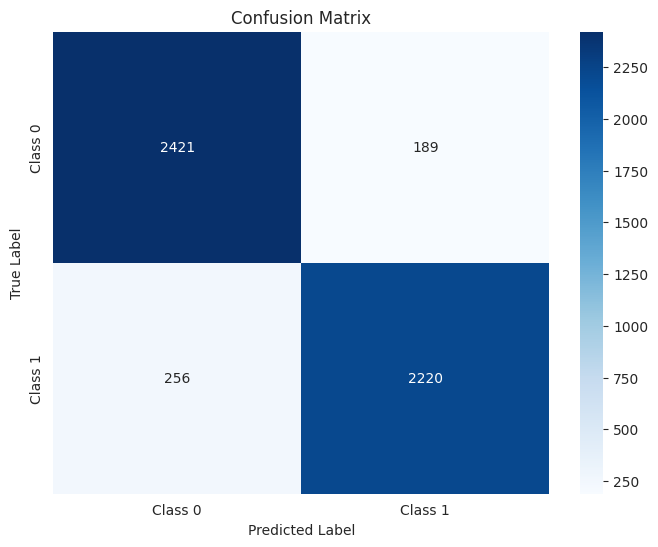

lgb_clf training set metrics 0.91172
Accuracy : 0.9117
Precision: 0.9242
Recall   : 0.8918
F1 Score : 0.9077

Confusion Matrix:
[[2429  181]
 [ 268 2208]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9006    0.9307    0.9154      2610
        True     0.9242    0.8918    0.9077      2476

    accuracy                         0.9117      5086
   macro avg     0.9124    0.9112    0.9116      5086
weighted avg     0.9121    0.9117    0.9117      5086



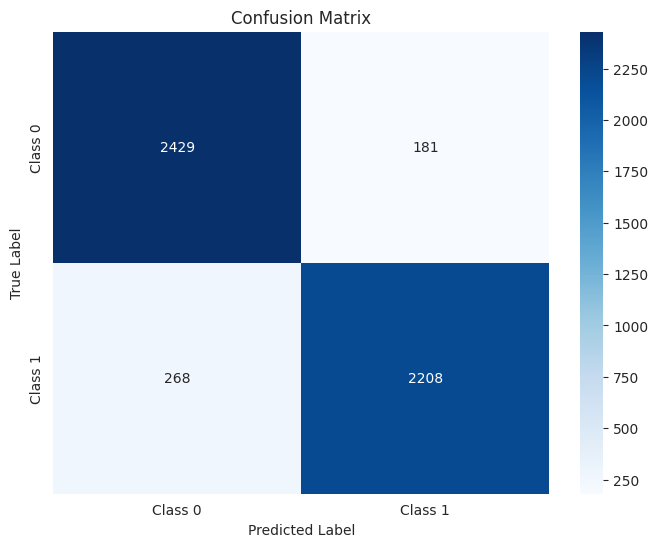

cat_clf training set metrics 0.91152
Accuracy : 0.9115
Precision: 0.9214
Recall   : 0.8946
F1 Score : 0.9078

Confusion Matrix:
[[2421  189]
 [ 261 2215]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9027    0.9276    0.9150      2610
        True     0.9214    0.8946    0.9078      2476

    accuracy                         0.9115      5086
   macro avg     0.9120    0.9111    0.9114      5086
weighted avg     0.9118    0.9115    0.9115      5086



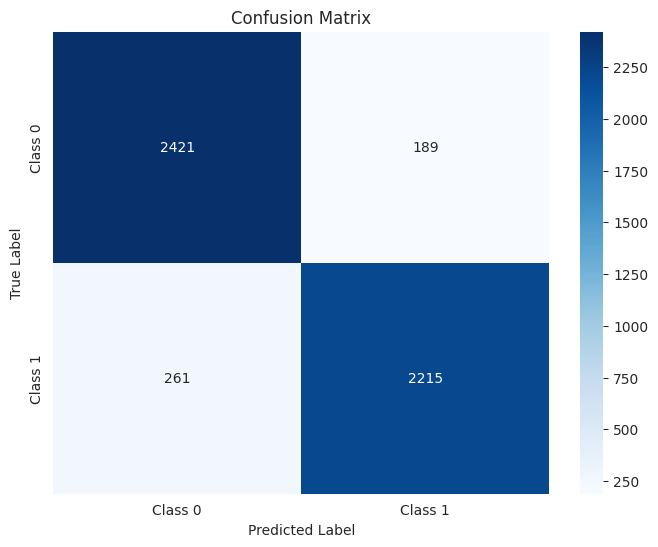

voting_clf training set metrics 0.9125
Accuracy : 0.9125
Precision: 0.9222
Recall   : 0.8958
F1 Score : 0.9088

Confusion Matrix:
[[2423  187]
 [ 258 2218]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9038    0.9284    0.9159      2610
        True     0.9222    0.8958    0.9088      2476

    accuracy                         0.9125      5086
   macro avg     0.9130    0.9121    0.9124      5086
weighted avg     0.9128    0.9125    0.9125      5086



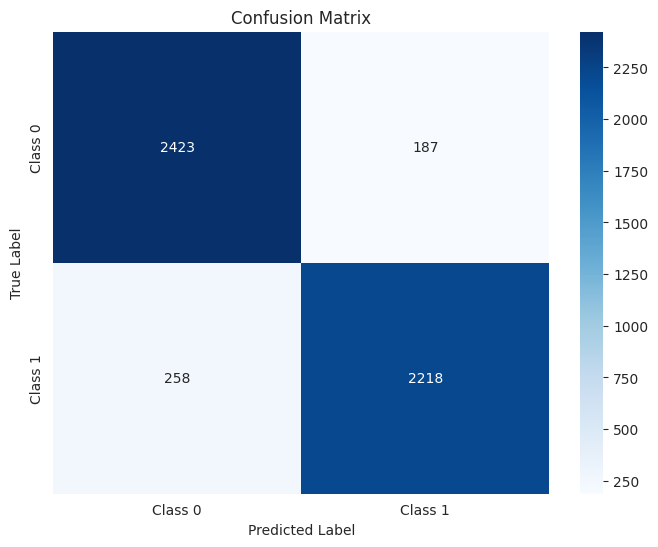


Best model: xgb_clf with accuracy 0.9125


In [16]:
best_name = None
best_acc = 0
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score']

# (["rf_clf",rf],
#                  ["svc_clf",svc],
#                  ["knn_clf",knn],
#                  ["ab_clf",ab],
#                  ["xgb_clf",xgb],
#                  ["lgb_clf",lgb],
#                  ["cat_clf",cat],
#                  ["voting_clf",voting])

#fit each model and print their accuracy, then print the best accuracy score
for name,clf in (["xgb_clf",xgb],
                 ["lgb_clf",lgb],
                 ["cat_clf",cat],
                 ["voting_clf",voting]):
    # fit the model
    clf.fit(df_tt[features], df_tt.isvandalism)

    # predict
    y_pred = clf.predict(df_ho[features])

    # get acc
    accuracy = accuracy_score(df_ho.isvandalism, y_pred)
    precision = precision_score(df_ho.isvandalism, y_pred)
    recall = recall_score(df_ho.isvandalism, y_pred)
    f1 = f1_score(df_ho.isvandalism, y_pred)
    confmat = confusion_matrix(df_ho.isvandalism, y_pred)

    # Print metrics
    print(name,"training set metrics")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confmat)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_ho.isvandalism, y_pred, digits=4))

    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                    yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # update best
    if accuracy > best_acc:
        best_acc = accuracy
        best_name = name

print(f"\nBest model: {best_name} with accuracy {np.round(best_acc, 5)}")


Note: when running xbg and lgb with optimized hyperparameters and catboost with default parameters, we got


```
xgb_clf training set accuracy 0.92686
lgb_clf training set accuracy 0.92489
cat_clf training set accuracy 0.92587
voting_clf training set accuracy 0.92764

Best model: voting_clf with accuracy 0.92764
```



Accuracy : 0.9271
Precision: 0.9270
Recall   : 0.9229
F1 Score : 0.9249

Confusion Matrix:
[[2430  180]
 [ 191 2285]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9271    0.9310    0.9291      2610
        True     0.9270    0.9229    0.9249      2476

    accuracy                         0.9271      5086
   macro avg     0.9271    0.9269    0.9270      5086
weighted avg     0.9271    0.9271    0.9271      5086



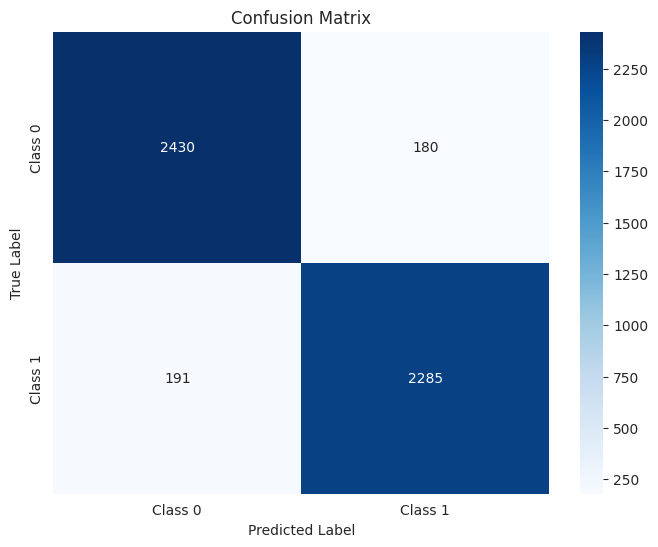

In [ ]:
#Metrics for the voting classifier

# Metrics
accuracy = accuracy_score(df_ho.isvandalism, y_pred)
precision = precision_score(df_ho.isvandalism, y_pred)
recall = recall_score(df_ho.isvandalism, y_pred)
f1 = f1_score(df_ho.isvandalism, y_pred)
confmat = confusion_matrix(df_ho.isvandalism, y_pred)

# Print metrics
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:")
print(confmat)

# Classification Report
print("\nClassification Report:")
print(classification_report(df_ho.isvandalism, y_pred, digits=4))

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()